## Trigger Word Detection

Welcome to the second and last programming assignment of Week 3! 

In this week's videos, you learned about applying deep learning to speech recognition. In this assignment, you will construct a speech dataset and implement an algorithm for trigger word detection (sometimes also called keyword detection, or wake word detection). 

* Trigger word detection is the technology that allows devices like Amazon Alexa, Google Home, Apple Siri, and Baidu DuerOS to wake up upon hearing a certain word.  
* For this exercise, our trigger word will be "activate". Every time it hears you say "activate", it will make a "chiming" sound. 
* By the end of this assignment, you will be able to record a clip of yourself talking, and have the algorithm trigger a chime when it detects you saying "activate". 
* After completing this assignment, perhaps you can also extend it to run on your laptop so that every time you say "activate" it starts up your favorite app, or turns on a network connected lamp in your house, or triggers some other event? 

<img src="https://drive.google.com/uc?export=view&id=1qo9Qkpkzmb8OMHq4w-JG4l6-YJboWlOd" style="width:1000px;height:150px;">

In this assignment you will learn to: 
- Structure a speech recognition project
- Synthesize and process audio recordings to create train/dev datasets
- Train a trigger word detection model and make predictions

Let's get started!

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/nlp-sequence-models/supplement/qHIve/h-ow-to-refresh-your-workspace).

## Table of Contents

- [Packages](#0)
- [1 - Data synthesis: Creating a Speech Dataset](#1)
    - [1.1 - Listening to the Data](#1-1)
    - [1.2 - From Audio Recordings to Spectrograms](#1-2)
    - [1.3 - Generating a Single Training Example](#1-3)
        - [Exercise 1 - is_overlapping](#ex-1)
        - [Exercise 2 - insert_audio_clip](#ex-2)
        - [Exercise 3 - insert_ones](#ex-3)
        - [Exercise 4 - create_training_example](#ex-4)
    - [1.4 - Full Training Set](#1-4)
    - [1.5 - Development Set](#1-5)
- [2 - The Model](#2)
    - [2.1 - Build the Model](#2-1)
        - [Exercise 5 - modelf](#ex-5)
    - [2.2 - Fit the Model](#2-2)
    - [2.3 - Test the Model](#2-3)
- [3 - Making Predictions](#3)
    - [3.1 - Test on Dev Examples](#3-1)
- [4 - Try Your Own Example! (OPTIONAL/UNGRADED)](#4)

<a name='0'></a>
## Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/Deep-Learning-Specialization-/Sequence Models/Trigger Word Detection'

/content/drive/MyDrive/Colab Notebooks/Deep-Learning-Specialization-/Sequence Models/Trigger Word Detection


In [ ]:
#!pip install pydub

In [ ]:
#!pip install numpy==1.18.4

In [ ]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

In [ ]:
np.__version__

'1.18.4'

<a name='1'></a>
## 1 - Data synthesis: Creating a Speech Dataset 

Let's start by building a dataset for your trigger word detection algorithm. 
* A speech dataset should ideally be as close as possible to the application you will want to run it on. 
* In this case, you'd like to detect the word "activate" in working environments (library, home, offices, open-spaces ...). 
* Therefore, you need to create recordings with a mix of positive words ("activate") and negative words (random words other than activate) on different background sounds. Let's see how you can create such a dataset. 

<a name='1-1'></a>
### 1.1 - Listening to the Data   

* One of your friends is helping you out on this project, and they've gone to libraries, cafes, restaurants, homes and offices all around the region to record background noises, as well as snippets of audio of people saying positive/negative words. This dataset includes people speaking in a variety of accents. 
* In the raw_data directory, you can find a subset of the raw audio files of the positive words, negative words, and background noise. You will use these audio files to synthesize a dataset to train the model. 
    * The "activate" directory contains positive examples of people saying the word "activate". 
    * The "negatives" directory contains negative examples of people saying random words other than "activate". 
    * There is one word per audio recording. 
    * The "backgrounds" directory contains 10 second clips of background noise in different environments.

Run the cells below to listen to some examples.

In [ ]:
IPython.display.Audio("./raw_data/activates/1.wav")

In [ ]:
IPython.display.Audio("./raw_data/negatives/4.wav")

In [ ]:
IPython.display.Audio("./raw_data/backgrounds/1.wav")

Output hidden; open in https://colab.research.google.com to view.

You will use these three types of recordings (positives/negatives/backgrounds) to create a labeled dataset.

<a name='1-2'></a>
### 1.2 - From Audio Recordings to Spectrograms

What really is an audio recording? 
* A microphone records little variations in air pressure over time, and it is these little variations in air pressure that your ear also perceives as sound. 
* You can think of an audio recording as a long list of numbers measuring the little air pressure changes detected by the microphone. 
* We will use audio sampled at 44100 Hz (or 44100 Hertz). 
    * This means the microphone gives us 44,100 numbers per second. 
    * Thus, a 10 second audio clip is represented by 441,000 numbers (= $10 \times 44,100$). 

#### Spectrogram
* It is quite difficult to figure out from this "raw" representation of audio whether the word "activate" was said. 
* In  order to help your sequence model more easily learn to detect trigger words, we will compute a *spectrogram* of the audio. 
* The spectrogram tells us how much different frequencies are present in an audio clip at any moment in time. 
* If you've ever taken an advanced class on signal processing or on Fourier transforms:
    * A spectrogram is computed by sliding a window over the raw audio signal, and calculating the most active frequencies in each window using a Fourier transform. 
    * If you don't understand the previous sentence, don't worry about it.

Let's look at an example. 

In [ ]:
IPython.display.Audio("audio_examples/example_train.wav")

Output hidden; open in https://colab.research.google.com to view.

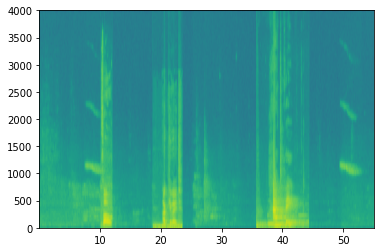

In [ ]:
x = graph_spectrogram("audio_examples/example_train.wav")

The graph above represents how active each frequency is (y axis) over a number of time-steps (x axis). 

<img src="https://drive.google.com/uc?export=view&id=1N6BLjupmbJBdy_a_-nV27gGWAiof-D5M" style="width:500px;height:200px;">
<center> **Figure 1**: Spectrogram of an audio recording </center>


* The color in the spectrogram shows the degree to which different frequencies are present (loud) in the audio at different points in time. 
* Green means a certain frequency is more active or more present in the audio clip (louder).
* Blue squares denote less active frequencies.
* The dimension of the output spectrogram depends upon the hyperparameters of the spectrogram software and the length of the input. 
* In this notebook, we will be working with 10 second audio clips as the "standard length" for our training examples. 
    * The number of timesteps of the spectrogram will be 5511. 
    * You'll see later that the spectrogram will be the input $x$ into the network, and so $T_x = 5511$.

In [ ]:
_, data = wavfile.read("audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


Now, you can define:

In [ ]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

#### Dividing into time-intervals
Note that we may divide a 10 second interval of time with different units (steps).
* Raw audio divides 10 seconds into 441,000 units.
* A spectrogram divides 10 seconds into 5,511 units.
    * $T_x = 5511$
* You will use a Python module `pydub` to synthesize audio, and it divides 10 seconds into 10,000 units.
* The output of our model will divide 10 seconds into 1,375 units.
    * $T_y = 1375$
    * For each of the 1375 time steps, the model predicts whether someone recently finished saying the trigger word "activate". 
* All of these are hyperparameters and can be changed (except the 441000, which is a function of the microphone). 
* We have chosen values that are within the standard range used for speech systems.

In [ ]:
Ty = 1375 # The number of time steps in the output of our model

<a name='1-3'></a>
### 1.3 - Generating a Single Training Example

#### Benefits of synthesizing data
Because speech data is hard to acquire and label, you will synthesize your training data using the audio clips of activates, negatives, and backgrounds. 
* It is quite slow to record lots of 10 second audio clips with random "activates" in it. 
* Instead, it is easier to record lots of positives and negative words, and record background noise separately (or download background noise from free online sources). 

#### Process for Synthesizing an audio clip
* To synthesize a single training example, you will:
    - Pick a random 10 second background audio clip
    - Randomly insert 0-4 audio clips of "activate" into this 10 sec. clip
    - Randomly insert 0-2 audio clips of negative words into this 10 sec. clip
* Because you had synthesized the word "activate" into the background clip, you know exactly when in the 10 second clip the "activate" makes its appearance. 
    * You'll see later that this makes it easier to generate the labels $y^{\langle t \rangle}$ as well. 

#### Pydub
* You will use the pydub package to manipulate audio. 
* Pydub converts raw audio files into lists of Pydub data structures.
    * Don't worry about the details of the data structures.
* Pydub uses 1ms as the discretization interval (1 ms is 1 millisecond = 1/1000 seconds).
    * This is why a 10 second clip is always represented using 10,000 steps. 

In [ ]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio('./raw_data/')

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
1579 

activate[1] len: different `activate` clips can have different lengths
916 



In [ ]:
# reposition the index of `negatives` list for unit test purpose 
negatives_temp = negatives
negatives[0]=negatives_temp[5]
negatives[1]=negatives_temp[1]
negatives[2]=negatives_temp[6]
negatives[3]=negatives_temp[4]
negatives[4]=negatives_temp[0]
negatives[5]=negatives_temp[8]
negatives[6]=negatives_temp[9]
negatives[7]=negatives_temp[2]
negatives[8]=negatives_temp[7]
negatives[8]=negatives_temp[3]

In [ ]:
# reposition the index of `activates` list for unit test purpose 
temp = activates[1] 
activates[1] = activates[0]
activates[0] = temp

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
916 

activate[1] len: different `activate` clips can have different lengths
1579 



#### Overlaying positive/negative 'word' audio clips on top of the background audio

* Given a 10 second background clip and a short audio clip containing a positive or negative word, you need to be able to "add" the word audio clip on top of the background audio.
* You will be inserting multiple clips of positive/negative words into the background, and you don't want to insert an "activate" or a random word somewhere that overlaps with another clip you had previously added. 
    * To ensure that the 'word' audio segments do not overlap when inserted, you will keep track of the times of previously inserted audio clips. 
* To be clear, when you insert a 1 second "activate" onto a 10 second clip of cafe noise, **you do not end up with an 11 sec clip.** 
    * The resulting audio clip is still 10 seconds long.
    * You'll see later how pydub allows you to do this. 

#### Label the positive/negative words
* Recall that the labels $y^{\langle t \rangle}$ represent whether or not someone has just finished saying "activate". 
    * $y^{\langle t \rangle} = 1$ when that clip has finished saying "activate".
    * Given a background clip, we can initialize $y^{\langle t \rangle}=0$ for all $t$, since the clip doesn't contain any "activate". 
* When you insert or overlay an "activate" clip, you will also update labels for $y^{\langle t \rangle}$.
    * Rather than updating the label of a single time step, we will update 50 steps of the output to have target label 1. 
    * Recall from the lecture on trigger word detection that updating several consecutive time steps can make the training data more balanced.
* You will train a GRU (Gated Recurrent Unit) to detect when someone has **finished** saying "activate". 

##### Example
* Suppose the synthesized "activate" clip ends at the 5 second mark in the 10 second audio - exactly halfway into the clip. 
* Recall that $T_y = 1375$, so timestep $687 = $ `int(1375*0.5)` corresponds to the moment 5 seconds into the audio clip. 
* Set $y^{\langle 688 \rangle} = 1$. 
* We will allow the GRU to detect "activate" anywhere within a short time-internal **after** this moment, so we actually **set 50 consecutive values** of the label $y^{\langle t \rangle}$ to 1. 
    * Specifically, we have $y^{\langle 688 \rangle} = y^{\langle 689 \rangle} = \cdots = y^{\langle 737 \rangle} = 1$.  

##### Synthesized data is easier to label
* This is another reason for synthesizing the training data: It's relatively straightforward to generate these labels $y^{\langle t \rangle}$ as described above. 
* In contrast, if you have 10sec of audio recorded on a microphone, it's quite time consuming for a person to listen to it and mark manually exactly when "activate" finished. 

#### Visualizing the labels
* Here's a figure illustrating the labels $y^{\langle t \rangle}$ in a clip.
    * We have inserted "activate", "innocent", "activate", "baby." 
    * Note that the positive labels "1" are associated only with the positive words. 

<img src="https://drive.google.com/uc?export=view&id=11gqEmLoGzCcFo6R9OO-8RWu7zzxqgWMC" style="width:500px;height:200px;">
<center> **Figure 2** </center>



#### Helper functions

To implement the training set synthesis process, you will use the following helper functions. 
* All of these functions will use a 1ms discretization interval
* The 10 seconds of audio is always discretized into 10,000 steps. 


1. `get_random_time_segment(segment_ms)`
    * Retrieves a random time segment from the background audio.
2. `is_overlapping(segment_time, existing_segments)`
    * Checks if a time segment overlaps with existing segments
3. `insert_audio_clip(background, audio_clip, existing_times)`
    * Inserts an audio segment at a random time in the background audio
    * Uses the functions `get_random_time_segment` and `is_overlapping`
4. `insert_ones(y, segment_end_ms)`
    * Inserts additional 1's into the label vector y after the word "activate"

#### Get a random time segment

* The function `get_random_time_segment(segment_ms)` returns a random time segment onto which we can insert an audio clip of duration `segment_ms`. 
* Please read through the code to make sure you understand what it is doing. 

In [ ]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

#### Check if audio clips are overlapping

* Suppose you have inserted audio clips at segments (1000,1800) and (3400,4500).
    * The first segment starts at step 1000 and ends at step 1800. 
    * The second segment starts at 3400 and ends at 4500.
* If we are considering whether to insert a new audio clip at (3000,3600) does this overlap with one of the previously inserted segments? 
    * In this case, (3000,3600) and (3400,4500) overlap, so we should decide against inserting a clip here.
* For the purpose of this function, define (100,200) and (200,250) to be overlapping, since they overlap at timestep 200. 
* (100,199) and (200,250) are non-overlapping. 

<a name='ex-1'></a>
### Exercise 1 -  is_overlapping

* Implement `is_overlapping(segment_time, existing_segments)` to check if a new time segment overlaps with any of the previous segments. 
* You will need to carry out 2 steps:

1. Create a "False" flag, that you will later set to "True" if you find that there is an overlap.
2. Loop over the previous_segments' start and end times. Compare these times to the segment's start and end times. If there is an overlap, set the flag defined in (1) as True. 

You can use:
```python
for ....:
        if ... <= ... and ... >= ...:
            ...
```
Hint: There is overlap if:
* The new segment starts before the previous segment ends **and**
* The new segment ends after the previous segment starts.

In [ ]:
# UNQ_C1
# GRADED FUNCTION: is_overlapping

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments: # @KEEP
        if segment_start<=previous_end and segment_end>=previous_start:
            overlap = True
            break
    ### END CODE HERE ###

    return overlap

In [ ]:
# UNIT TEST
def is_overlapping_test(target):
    assert target((670, 1430), []) == False, "Overlap with an empty list must be False"
    assert target((500, 1000), [(100, 499), (1001, 1100)]) == False, "Almost overlap, but still False"
    assert target((750, 1250), [(100, 750), (1001, 1100)]) == True, "Must overlap with the end of first segment"
    assert target((750, 1250), [(300, 600), (1250, 1500)]) == True, "Must overlap with the begining of second segment"
    assert target((750, 1250), [(300, 600), (600, 1500), (1600, 1800)]) == True, "Is contained in second segment"
    assert target((800, 1100), [(300, 600), (900, 1000), (1600, 1800)]) == True, "New segment contains the second segment"

    print("\033[92m All tests passed!")
    
is_overlapping_test(is_overlapping)

 All tests passed!


In [ ]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


**Expected Output**:

<table>
    <tr>
        <td>
            **Overlap 1**
        </td>
        <td>
           False
        </td>
    </tr>
    <tr>
        <td>
            **Overlap 2**
        </td>
        <td>
           True
        </td>
    </tr>
</table>

#### Insert audio clip

* Let's use the previous helper functions to insert a new audio clip onto the 10 second background at a random time.
* We will ensure that any newly inserted segment doesn't overlap with previously inserted segments. 

<a name='ex-2'></a>
### Exercise 2 - insert_audio_clip
* Implement `insert_audio_clip()` to overlay an audio clip onto the background 10sec clip. 
* You implement 4 steps:

1. Get the length of the audio clip that is to be inserted.
    * Get a random time segment whose duration equals the duration of the audio clip that is to be inserted.
2. Make sure that the time segment does not overlap with any of the previous time segments. 
    * If it is overlapping, then go back to step 1 and pick a new time segment.
3. Append the new time segment to the list of existing time segments
    * This keeps track of all the segments you've inserted.  
4. Overlay the audio clip over the background using pydub. We have implemented this for you.

In [ ]:
# UNQ_C2
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. To avoid an endless loop
    # we retry 5 times(≈ 2 lines)
    retry = 5 # @KEEP 
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1
    ### END CODE HERE ###
        #print(segment_time)
    # if last try is not overlaping, insert it to the background
    if not is_overlapping(segment_time, previous_segments):
    ### START CODE HERE ### 
        # Step 3: Append the new segment_time to the list of previous_segments (≈ 1 line)
        previous_segments.append(segment_time)
    ### END CODE HERE ###
        # Step 4: Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
    else:
        #print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)
    
    return new_background, segment_time

In [ ]:
# UNIT TEST
def insert_audio_clip_test(target):
    np.random.seed(5)
    audio_clip, segment_time = target(backgrounds[0], activates[0], [(0, 4400)])
    duration = segment_time[1] - segment_time[0]
    assert segment_time[0] > 4400, "Error: The audio clip is overlaping with the first segment"
    assert duration + 1 == len(activates[0]) , "The segment length must match the audio clip length"
    assert audio_clip != backgrounds[0] , "The audio clip must be different than the pure background"
    assert segment_time == (7286, 8201), f"Wrong segment. Expected: Expected: (7286, 8201) got:{segment_time}"

    # Not possible to insert clip into background
    audio_clip, segment_time = target(backgrounds[0], activates[0], [(0, 9999)])
    assert segment_time == (10000, 10000), "Segment must match the out by max-retry mark"
    assert audio_clip == backgrounds[0], "output audio clip must be exactly the same input background"

    print("\033[92m All tests passed!")

insert_audio_clip_test(insert_audio_clip)

 All tests passed!


In [ ]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Output hidden; open in https://colab.research.google.com to view.

**Expected Output**

<table>
    <tr>
        <td>
            **Segment Time**
        </td>
        <td>
           (2254, 3169)
        </td>
    </tr>
</table>

In [ ]:
# Expected audio
IPython.display.Audio("audio_examples/insert_reference.wav")

Output hidden; open in https://colab.research.google.com to view.

#### Insert ones for the labels of the positive target

* Implement code to update the labels $y^{\langle t \rangle}$, assuming you just inserted an "activate" audio clip.
* In the code below, `y` is a `(1,1375)` dimensional vector, since $T_y = 1375$. 
* If the "activate" audio clip ends at time step $t$, then set $y^{\langle t+1 \rangle} = 1$ and also set the next 49 additional consecutive values to 1.
    * Notice that if the target word appears near the end of the entire audio clip, there may not be 50 additional time steps to set to 1.
    * Make sure you don't run off the end of the array and try to update `y[0][1375]`, since the valid indices are `y[0][0]` through `y[0][1374]` because $T_y = 1375$. 
    * So if "activate" ends at step 1370, you would get only set `y[0][1371] = y[0][1372] = y[0][1373] = y[0][1374] = 1`

<a name='ex-3'></a>
### Exercise 3 - insert_ones 
Implement `insert_ones()`. 
* You can use a for loop. 
* If you want to use Python's array slicing operations, you can do so as well.
* If a segment ends at `segment_end_ms` (using a 10000 step discretization),
    * To convert it to the indexing for the outputs $y$ (using a $1375$ step discretization), we will use this formula:  
```
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
```

In [ ]:
# UNQ_C3
# GRADED FUNCTION: insert_ones

def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    _, Ty = y.shape
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    if segment_end_y < Ty:
        # Add 1 to the correct index in the background label (y)
        ### START CODE HERE ### (≈ 3 lines)
        for i in range(segment_end_y + 1, segment_end_y + 51):
            if i < Ty:
                y[0, i] = 1
        ### END CODE HERE ###
    
    return y

In [ ]:
# UNIT TEST
import random
def insert_ones_test(target):
    segment_end_y = random.randrange(0, Ty - 50) 
    segment_end_ms = int(segment_end_y * 10000.4) / Ty;    
    arr1 = target(np.zeros((1, Ty)), segment_end_ms)

    assert type(arr1) == np.ndarray, "Wrong type. Output must be a numpy array"
    assert arr1.shape == (1, Ty), "Wrong shape. It must match the input shape"
    assert np.sum(arr1) == 50, "It must insert exactly 50 ones"
    assert arr1[0][segment_end_y - 1] == 0, f"Array at {segment_end_y - 1} must be 0"
    assert arr1[0][segment_end_y] == 0, f"Array at {segment_end_y} must be 0"
    assert arr1[0][segment_end_y + 1] == 1, f"Array at {segment_end_y + 1} must be 1"
    assert arr1[0][segment_end_y + 50] == 1, f"Array at {segment_end_y + 50} must be 1"
    assert arr1[0][segment_end_y + 51] == 0, f"Array at {segment_end_y + 51} must be 0"

    print("\033[92m All tests passed!")
    
insert_ones_test(insert_ones)

 All tests passed!


sanity checks: 0.0 1.0 0.0


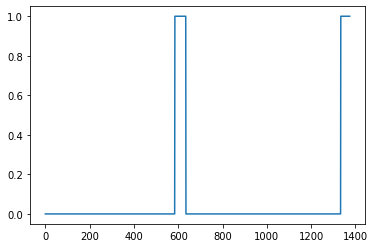

In [ ]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

**Expected Output**
<table>
    <tr>
        <td>
            **sanity checks**:
        </td>
        <td>
           0.0 1.0 0.0
        </td>
    </tr>
</table>
<img src="https://drive.google.com/uc?export=view&id=1UasSZr2R68Lr1UEVc2qpzxdf-fQBRuWW" style="width:320;height:240px;">

#### Creating a training example
Finally, you can use `insert_audio_clip` and `insert_ones` to create a new training example.


<a name='ex-4'></a>
### Exercise 4 - create_training_example

Implement `create_training_example()`. You will need to carry out the following steps:

1. Initialize the label vector $y$ as a numpy array of zeros and shape $(1, T_y)$.
2. Initialize the set of existing segments to an empty list.
3. Randomly select 0 to 4 "activate" audio clips, and insert them onto the 10 second clip. Also insert labels at the correct position in the label vector $y$.
4. Randomly select 0 to 2 negative audio clips, and insert them into the 10 second clip. 

In [ ]:
# UNQ_C4
# GRADED FUNCTION: create_training_example

def create_training_example(background, activates, negatives, Ty):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1,Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates: # @KEEP
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y" at segment_end
        y = insert_ones(y, segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives: # @KEEP
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

 All tests passed!


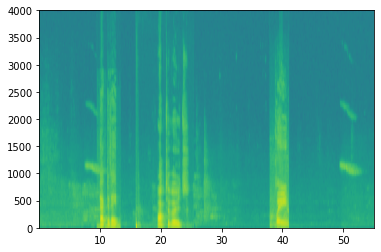

In [ ]:
# UNIT TEST
def create_training_example_test(target):
    np.random.seed(18)
    x, y = target(backgrounds[0], activates, negatives, 1375)
    
    assert type(x) == np.ndarray, "Wrong type for x"
    assert type(y) == np.ndarray, "Wrong type for y"
    assert tuple(x.shape) == (101, 5511), "Wrong shape for x"
    assert tuple(y.shape) == (1, 1375), "Wrong shape for y"
    assert np.all(x > 0), "All x values must be higher than 0"
    assert np.all(y >= 0), "All y values must be higher or equal than 0"
    assert np.all(y <= 1), "All y values must be smaller or equal than 1"
    assert np.sum(y) >= 50, "It must contain at least one activate"
    assert np.sum(y) % 50 == 0, "Sum of activate marks must be a multiple of 50"
    #assert np.isclose(np.linalg.norm(x), 39745552.52075), "Spectrogram is wrong. Check the parameters passed to the insert_audio_clip function"

    print("\033[92m All tests passed!")

create_training_example_test(create_training_example)

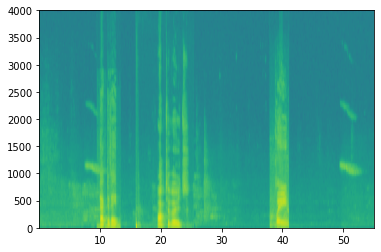

In [ ]:
# Set the random seed
np.random.seed(18)
x, y = create_training_example(backgrounds[0], activates, negatives, Ty)

**Expected Output**
<img src="https://drive.google.com/uc?export=view&id=1fUYD0DMs2dfxPC01Ww3j54D3pxYe3I2w" style="width:320;height:240px;">

Now you can listen to the training example you created and compare it to the spectrogram generated above.

In [ ]:
IPython.display.Audio("train.wav")

Output hidden; open in https://colab.research.google.com to view.

**Expected Output**

In [ ]:
IPython.display.Audio("audio_examples/train_reference.wav")

Output hidden; open in https://colab.research.google.com to view.

Finally, you can plot the associated labels for the generated training example.

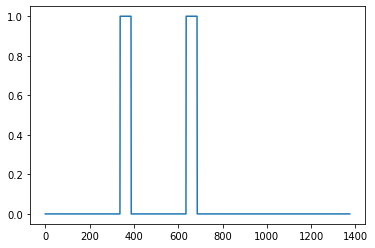

In [ ]:
plt.plot(y[0])

**Expected Output**
<img src="images/train_label.png" style="width:320;height:240px;">

<a name='1-4'></a>
### 1.4 - Full Training Set

* You've now implemented the code needed to generate a single training example. 
* We used this process to generate a large training set. 
* To save time, we generate a smaller training set of 32 examples. 

0
10
20
30


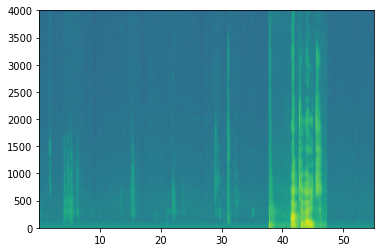

In [ ]:
# START SKIP FOR GRADING
np.random.seed(4543)
nsamples = 32
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)
# END SKIP FOR GRADING

You would like to save your dataset into a file that you can load later if you work in a more realistic environment. We let you the following code for reference. Don't try to run it into Coursera since the file system is read-only, and you cannot save files.

In [ ]:
# Save the data for further uses
# np.save(f'./XY_train/X.npy', X)
# np.save(f'./XY_train/Y.npy', Y)
# Load the preprocessed training examples
# X = np.load("./XY_train/X.npy")
# Y = np.load("./XY_train/Y.npy")

<a name='1-5'></a>
### 1.5 - Development Set

* To test our model, we recorded a development set of 25 examples. 
* While our training data is synthesized, we want to create a development set using the same distribution as the real inputs. 
* Thus, we recorded 25 10-second audio clips of people saying "activate" and other random words, and labeled them by hand. 
* This follows the principle described in Course 3 "Structuring Machine Learning Projects" that we should create the dev set to be as similar as possible to the test set distribution
    * This is why our **dev set uses real audio** rather than synthesized audio. 


In [ ]:
# Load preprocessed dev set examples
X_dev = np.load("./XY_dev/X_dev.npy")
Y_dev = np.load("./XY_dev/Y_dev.npy")

<a name='2'></a>
## 2 - The Model

* Now that you've built a dataset, let's write and train a trigger word detection model! 
* The model will use 1-D convolutional layers, GRU layers, and dense layers. 
* Let's load the packages that will allow you to use these layers in Keras. This might take a minute to load. 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

<a name='2-1'></a>
### 2.1 - Build the Model

Our goal is to build a network that will ingest a spectrogram and output a signal when it detects the trigger word. This network will use 4 layers:
    * A convolutional layer
    * Two GRU layers
    * A dense layer. 

Here is the architecture we will use.

<img src="https://drive.google.com/uc?export=view&id=1VYmLsKT7tat7G4VFe3e16EES14v32U35" style="width:600px;height:600px;">
<center> **Figure 3** </center>

##### 1D convolutional layer
One key layer of this model is the 1D convolutional step (near the bottom of Figure 3). 
* It inputs the 5511 step spectrogram.  Each step is a vector of 101 units.
* It outputs a 1375 step output
* This output is further processed by multiple layers to get the final $T_y = 1375$ step output. 
* This 1D convolutional layer plays a role similar to the 2D convolutions you saw in Course 4, of extracting low-level features and then possibly generating an output of a smaller dimension. 
* Computationally, the 1-D conv layer also helps speed up the model because now the GRU  can process only 1375 timesteps rather than 5511 timesteps. 

##### GRU, dense and sigmoid
* The two GRU layers read the sequence of inputs from left to right.
* A dense plus sigmoid layer makes a prediction for $y^{\langle t \rangle}$. 
* Because $y$ is a binary value (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1, corresponding to the user having just said "activate".

#### Unidirectional RNN
* Note that we use a **unidirectional RNN** rather than a bidirectional RNN. 
* This is really important for trigger word detection, since we want to be able to detect the trigger word almost immediately after it is said. 
* If we used a bidirectional RNN, we would have to wait for the whole 10sec of audio to be recorded before we could tell if "activate" was said in the first second of the audio clip.  

#### Implement the model

In the following model, the input of each layer is the output of the previous one. Implementing the model can be done in four steps. 

**Step 1**: CONV layer. Use `Conv1D()` to implement this, with 196 filters, 
a filter size of 15 (`kernel_size=15`), and stride of 4. [conv1d](https://keras.io/layers/convolutional/#conv1d)

```Python
output_x = Conv1D(filters=...,kernel_size=...,strides=...)(input_x)
```
* Follow this with batch normalization.  No parameters need to be set.

```Python
output_x = BatchNormalization()(input_x)
```
* Follow this with a ReLu activation.  Note that we can pass in the name of the desired activation as a string, all in lowercase letters.

```Python
output_x = Activation("...")(input_x)
```

* Follow this with dropout, using a rate of 0.8 

```Python
output_x = Dropout(rate=...)(input_x)
```


**Step 2**: First GRU layer. To generate the GRU layer, use 128 units.
```Python
output_x = GRU(units=..., return_sequences = ...)(input_x)
```
* Return sequences instead of just the last time step's prediction to ensure that all the GRU's hidden states are fed to the next layer. 
* Follow this with dropout, using a rate of 0.8.
* Follow this with batch normalization.  No parameters need to be set.
```Python
output_x = BatchNormalization()(input_x)
```

**Step 3**: Second GRU layer. This has the same specifications as the first GRU layer.
* Follow this with a dropout, batch normalization, and then another dropout.

**Step 4**: Create a time-distributed dense layer as follows: 
```Python
output_x = TimeDistributed(Dense(1, activation = "sigmoid"))(input_x)
```
This creates a dense layer followed by a sigmoid, so that the parameters used for the dense layer are the same for every time step.  
Documentation:
* [Keras documentation on wrappers](https://keras.io/layers/wrappers/).  
* To learn more, you can read this blog post [How to Use the TimeDistributed Layer in Keras](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/).

<a name='ex-5'></a>
### Exercise 5 - modelf

Implement `modelf()`, the architecture is presented in Figure 3.

In [ ]:
# UNQ_C5
# GRADED FUNCTION: modelf

def modelf(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    # Add a Conv1D with 196 units, kernel size of 15 and stride of 4
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch normalization
    X = BatchNormalization()(X)
    # ReLu activation
    X = Activation("relu")(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)                                  

    # Step 2: First GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X) 
    # Batch normalization.
    X = BatchNormalization()(X)                           
    
    # Step 3: Second GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)        
    # Batch normalization
    X = BatchNormalization()(X) 
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)                                  
    
    # Step 4: Time-distributed dense layer (≈1 line)
    # TimeDistributed with sigmoid activation 
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) 

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [ ]:
# UNIT TEST
from test_utils import *

def modelf_test(target):
    Tx = 5511
    n_freq = 101
    model = target(input_shape = (Tx, n_freq))
    expected_model = [['InputLayer', [(None, 5511, 101)], 0],
                     ['Conv1D', (None, 1375, 196), 297136, 'valid', 'linear', (4,), (15,), 'GlorotUniform'],
                     ['BatchNormalization', (None, 1375, 196), 784],
                     ['Activation', (None, 1375, 196), 0],
                     ['Dropout', (None, 1375, 196), 0, 0.8],
                     ['GRU', (None, 1375, 128), 125184, True],
                     ['Dropout', (None, 1375, 128), 0, 0.8],
                     ['BatchNormalization', (None, 1375, 128), 512],
                     ['GRU', (None, 1375, 128), 99072, True],
                     ['Dropout', (None, 1375, 128), 0, 0.8],
                     ['BatchNormalization', (None, 1375, 128), 512],
                     ['Dropout', (None, 1375, 128), 0, 0.8],
                     ['TimeDistributed', (None, 1375, 1), 129, 'sigmoid']]
    comparator(summary(model), expected_model)
    
    
modelf_test(modelf)

All tests passed!


In [ ]:
model = modelf(input_shape = (Tx, n_freq))

Let's print the model summary to keep track of the shapes.

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5511, 101)]       0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1375, 196)         297136    
                                                                 
 batch_normalization_3 (Batc  (None, 1375, 196)        784       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 1375, 196)         0         
                                                                 
 dropout_4 (Dropout)         (None, 1375, 196)         0         
                                                                 
 gru_2 (GRU)                 (None, 1375, 128)         125184    
                                                           

**Expected Output**:

<table>
    <tr>
        <td>
            **Total params**
        </td>
        <td>
           523,329
        </td>
    </tr>
    <tr>
        <td>
            **Trainable params**
        </td>
        <td>
           522,425
        </td>
    </tr>
    <tr>
        <td>
            **Non-trainable params**
        </td>
        <td>
           904
        </td>
    </tr>
</table>

The output of the network is of shape (None, 1375, 1) while the input is (None, 5511, 101). The Conv1D has reduced the number of steps from 5511 to 1375. 

<a name='2-2'></a>
### 2.2 - Fit the Model

* Trigger word detection takes a long time to train. 
* To save time, we've already trained a model for about 3 hours on a GPU using the architecture you built above, and a large training set of about 4000 examples. 
* Let's load the model. 

In [ ]:
from tensorflow.keras.models import model_from_json

json_file = open('./models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('./models/model.h5')

<a name='2-2-1'></a>
#### 2.2.1 Block Training for BatchNormalization Layers

If you are going to fine-tune a pretrained model, it is important that you block the weights of all your batchnormalization layers. If you are going to train a new model from scratch, skip the next cell. 

In [ ]:
model.layers[2].trainable = False
model.layers[7].trainable = False
model.layers[10].trainable = False

You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for two epochs and with a small training set of 32 examples. 

In [ ]:
opt = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit(X, Y, batch_size = 16, epochs=1)

2/2 [==============================] - 11s 3s/step - loss: 0.1735 - accuracy: 0.9433


<a name='2-3'></a>
### 2.3 - Test the Model

Finally, let's see how your model performs on the dev set.

In [ ]:
loss, acc, = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

1/1 [==============================] - 2s 2s/step - loss: 0.1887 - accuracy: 0.9239
Dev set accuracy =  0.9239272475242615


This looks pretty good! 
* However, accuracy isn't a great metric for this task
    * Since the labels are heavily skewed to 0's, a neural network that just outputs 0's would get slightly over 90% accuracy. 
* We could define more useful metrics such as F1 score or Precision/Recall. 
    * Let's not bother with that here, and instead just empirically see how the model does with some predictions.

<a name='3'></a>
## 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

<!--
can use your model to make predictions on new audio clips.

You will first need to compute the predictions for an input audio clip.

**Exercise**: Implement predict_activates(). You will need to do the following:

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. Use forward propagation on your model to compute the prediction at each output step
!-->

In [ ]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    
    # Correct the amplitude of the input file before prediction 
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    file_handle = audio_clip.export("tmp.wav", format="wav")
    filename = "tmp.wav"

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

#### Insert a chime to acknowledge the "activate" trigger
* Once you've estimated the probability of having detected the word "activate" at each output step, you can trigger a "chiming" sound to play when the probability is above a certain threshold. 
* $y^{\langle t \rangle}$ might be near 1 for many values in a row after "activate" is said, yet we want to chime only once. 
    * So we will insert a chime sound at most once every 75 output steps. 
    * This will help prevent us from inserting two chimes for a single instance of "activate". 
    * This plays a role similar to non-max suppression from computer vision.

<!-- 
**Exercise**: Implement chime_on_activate(). You will need to do the following:

1. Loop over the predicted probabilities at each output step
2. When the prediction is larger than the threshold and more than 75 consecutive time steps have passed, insert a "chime" sound onto the original audio clip

Use this code to convert from the 1,375 step discretization to the 10,000 step discretization and insert a "chime" using pydub:

` audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio.duration_seconds)*1000)
`
!--> 

In [ ]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 20 consecutive output steps have passed
        if consecutive_timesteps > 20:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds) * 1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        # if amplitude is smaller than the threshold reset the consecutive_timesteps counter
        if predictions[0, i, 0] < threshold:
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

<a name='3-1'></a>
### 3.1 - Test on Dev Examples

Let's explore how our model performs on two unseen audio clips from the development set. Lets first listen to the two dev set clips. 

In [ ]:
IPython.display.Audio("./raw_data/dev/1.wav")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
IPython.display.Audio("./raw_data/dev/2.wav")

Output hidden; open in https://colab.research.google.com to view.

Now lets run the model on these audio clips and see if it adds a chime after "activate"!

In [ ]:
filename = "./raw_data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
filename  = "./raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

Output hidden; open in https://colab.research.google.com to view.

### Congratulations 

You've come to the end of this assignment! 

#### Here's what you should remember:
- Data synthesis is an effective way to create a large training set for speech problems, specifically trigger word detection. 
- Using a spectrogram and optionally a 1D conv layer is a common pre-processing step prior to passing audio data to an RNN, GRU or LSTM.
- An end-to-end deep learning approach can be used to build a very effective trigger word detection system. 

*Congratulations* on finishing this assignment!

<a name='4'></a>
## 4 - Try Your Own Example! (OPTIONAL/UNGRADED)

In this optional and ungraded portion of this notebook, you can try your model on your own audio clips! 

* Record a 10 second audio clip of you saying the word "activate" and other random words, and upload it to the Coursera hub as `myaudio.wav`. 
* Be sure to upload the audio as a wav file. 
* If your audio is recorded in a different format (such as mp3) there is free software that you can find online for converting it to wav. 
* If your audio recording is not 10 seconds, the code below will either trim or pad it as needed to make it 10 seconds. 

In [ ]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

Once you've uploaded your audio file to Coursera, put the path to your file in the variable below.

In [ ]:
your_filename = "audio_examples/my_audio.wav"

In [ ]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded 

Output hidden; open in https://colab.research.google.com to view.

Finally, use the model to predict when you say activate in the 10 second audio clip, and trigger a chime. If beeps are not being added appropriately, try to adjust the chime_threshold.

In [ ]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")

Output hidden; open in https://colab.research.google.com to view.